## Verarbeitung der GPM-IMERG HDF5 Dateien

- Entpacken der HDF5 Dateien
- Extraktion des AOI (Bounding Box)
- Umrechnung mm / h in mm / Monat
- Berechnung des langjährigen Maximums je Zelle (0.1° x 0.1°)
- Bestimmung des Monats & Jahres, mit größter NS-Anomalie (Durchschnitt aller Zellen im AOI)

In [204]:
import os

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

from datetime import datetime as dt

import xarray as xr
import calendar

# Umrechnen des Monatsdurchschnitts von mm / hr in Monatssumme mm / month:
def accumulate_precip(data, timestamp):
    real_timestamp = dt.utcfromtimestamp(timestamp).strftime('%Y-%m-%d').split("-")

    # mm / d:
    data = data * 24

    # mm / month: Fallunterscheidung nötig für unterschiedlich lange Monate & Schaltjahre
    if real_timestamp[1] in ["01", "03", "05", "07", "08", "10", "12"]:
        data *= 31
        print("long month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp[1] == "02" and calendar.isleap(int(real_timestamp[0])):
        data *= 29
        print("short month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp == "02" and not calendar.isleap(int(real_timestamp[0])):
        data *= 28
        print("very short month") # min:  ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    else:
        data *= 30
        print("medium month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))
    
    return data


# Liest Werte des AOI aus HDF5-Datei aus und gibt ein xarray monatlich akkumulierter Werte zurück
def xr_aoi(FILE_NAME, LAT_RANGE, LON_RANGE):
        
    with h5py.File(FILE_NAME, mode='r') as f:
        # Group-Name & Variable im HDF5-File  
        name = '/Grid/precipitation'

        # Zeitstempel vom ersten Tag des Monats in Unix-Zeit
        unix_timestamp = f['Grid/time'][0]
        # Umrechnung in UTC-Zeit
        utc_timestamp = dt.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d')    

        # Einlesen der Niederschlagsdaten: gegeben in mm / hr
        data = f[name][0,:,:]

        # Einlesen des Füllwertes aus den Attributen
        _FillValue = f[name].attrs['_FillValue']

        # Ersetzen des Füllwertes durch nan
        data[data == _FillValue] = np.nan
        
        # Umrechnen von mm / hr in Monatssumme
        data = accumulate_precip(data, unix_timestamp)

        #units = f[name].attrs['units']

        # Einlesen der Breitenkoordinaten
        lat = f['Grid/lat'][ : ]
        #print(lat)

        # Einlesen der Längenkoordinaten
        lon = f['Grid/lon'][ : ]
        #print(lon)

        # Zuweisung von Koordinatenskalen für neues xarray
        coords =  {
            'lon': lon,
            'lat': lat,  
            'time': dt.utcfromtimestamp(unix_timestamp)
            }
        
        # Definition von zusätzlichen Attributen
        attrs = {
            'fill_value': _FillValue
        }

        # Anlegen des xarrays mit allen NS-Daten und obigen Definitionen
        da = xr.DataArray(
            data, 
            coords=coords, 
            dims=['lon', 'lat'],
            attrs=attrs
            )
        #print(da)

        # Extraktion der Werte für AOI
        da_sel = da.sel({
                'lon': LON_RANGE,
                'lat': LAT_RANGE                
                },
                method='nearest',
                tolerance=0.09
                )
        
        print(da_sel.coords)
        print("min: ", np.nanmin(da_sel.values), ", max: ", np.nanmax(da_sel.values), ", mean: ", np.nanmean(da_sel.values))

        return da_sel

# Plottet die Werte eines xarrays
def plot_aoi(data, title_str="DEFAULT TITLE", axis_label="DEFAULT LABEL"):
    # Es soll ein Rahmen um das AOI von 8° in alle Richtungen geplottet werden
    try:
        m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]-8), urcrnrlat=(LAT_BOUNDING[1]+8),
                llcrnrlon=(LON_BOUNDING[0]-8), urcrnrlon=(LON_BOUNDING[1]+8)
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    # Liegt einer der Werte außerhalb des Werteraums [-90;90] bzw. [-180;180] wird kein Rahmen geplottet
    except ValueError:
                m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]), urcrnrlat=(LAT_BOUNDING[1]),
                llcrnrlon=(LON_BOUNDING[0]), urcrnrlon=(LON_BOUNDING[1])
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.2)
    m.drawparallels(np.arange(
        (LAT_BOUNDING[0]) - 15, 
        (LAT_BOUNDING[1] + 15), 
        ( (LAT_BOUNDING[1] - LAT_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.drawmeridians(
        np.arange(
        (LON_BOUNDING[0]) - 15, 
        (LON_BOUNDING[1] + 15), 
        ( (LON_BOUNDING[1] - LON_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.pcolormesh(
        LON_RANGE,
        LAT_RANGE,
        data.T,
        latlon=True
        )
    cb = m.colorbar()    
    cb.set_label(axis_label)

    plt.title(f'{title_str} {str(data.time.values)[0:7]}') # Abschneiden des restlichen Zeitstempels
 


In [189]:
DATA_PATH = './data/GPM_Data_2000_2021'
#DATA_PATH = './data/GPM_Data_Small'

LAT_BOUNDING = sorted([-10 , 25])
LON_BOUNDING = sorted([20 , 45])

# Anlegen von Arrays mit Größe der Bounding Box & passender Auflösung
LAT_RANGE = np.arange(LAT_BOUNDING[0], LAT_BOUNDING[1], 0.1)
LON_RANGE = np.arange(LON_BOUNDING[0], LON_BOUNDING[1], 0.1)

# Liste um die xarray-Monatsniederschläge temporär zu speichern
data_array_list = []

# Sortieren der Dateinamen: alt nach neu
filepaths = sorted(os.listdir(DATA_PATH))


for filename in filepaths:
    # Überspringe alle nicht-HDF5 Dateien
    if filename[-4:] != 'HDF5': 
        print(f'Unpassendes Dateiformat:\n"{filename}"\nUeberspringe Datei')
        continue

    # Zusammmensetzen von Speicherpfad und Dateiname
    path_file = os.sep.join([DATA_PATH, filename])

    # Anfügen der akkumulierten Monatsniederschläge für das AOI an temporäre Liste
    data_array_list.append(xr_aoi(path_file, LAT_RANGE, LON_RANGE))

# Stack der Monatsniederschläge entlang der Zeitachse für eine Zeitreihe
xr_data_stack = xr.concat(data_array_list, 'time' )


medium month
Coordinates:
  * lon      (lon) float32 20.05 20.15 20.25 20.25 ... 44.55 44.75 44.85 44.95
  * lat      (lat) float32 -9.95 -9.85 -9.75 -9.65 ... 24.65 24.75 24.75 24.85
    time     datetime64[ns] 2000-06-01
min:  0.0 , max:  425.12067 , mean:  52.21536
long month
Coordinates:
  * lon      (lon) float32 20.05 20.15 20.25 20.25 ... 44.55 44.75 44.85 44.95
  * lat      (lat) float32 -9.95 -9.85 -9.75 -9.65 ... 24.65 24.75 24.75 24.85
    time     datetime64[ns] 2000-07-01
min:  0.0 , max:  522.34216 , mean:  66.42364
long month
Coordinates:
  * lon      (lon) float32 20.05 20.15 20.25 20.25 ... 44.55 44.75 44.85 44.95
  * lat      (lat) float32 -9.95 -9.85 -9.75 -9.65 ... 24.65 24.75 24.75 24.85
    time     datetime64[ns] 2000-08-01
min:  0.0 , max:  534.54956 , mean:  79.490425
medium month
Coordinates:
  * lon      (lon) float32 20.05 20.15 20.25 20.25 ... 44.55 44.75 44.85 44.95
  * lat      (lat) float32 -9.95 -9.85 -9.75 -9.65 ... 24.65 24.75 24.75 24.85
    time    

In [190]:
july_stack = xr_data_stack.sel(time= (xr_data_stack.time.dt.month == 7) ) # Zugriff auf alle Monate 7 --> Juli

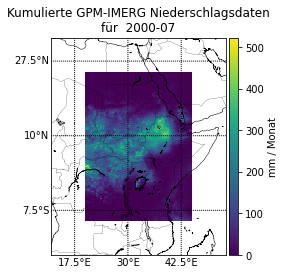

In [191]:
plot_aoi(july_stack[0], "Kumulierte GPM-IMERG Niederschlagsdaten\nfür ", "mm / Monat")

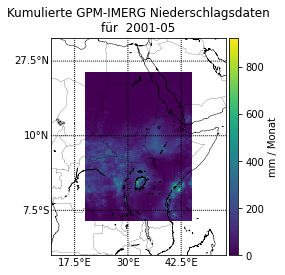

In [192]:
may_stack = xr_data_stack.sel(time= (xr_data_stack.time.dt.month == 5) )
plot_aoi(may_stack[0], "Kumulierte GPM-IMERG Niederschlagsdaten\nfür ", "mm / Monat")

In [193]:
# Gruppieren der Monate 1-12 --> Index startet bei 1!
grouped_stacks = xr_data_stack.groupby(xr_data_stack.time.dt.month) 
grouped_stacks[6][-1] # letztes Jahr des Monats Juni

<xarray.DataArray (lon: 250, lat: 350)>
array([[1.8192722e+00, 1.8994398e+00, 1.9584160e+00, ..., 1.1869002e-02,
        1.1869002e-02, 1.0287423e-02],
       [1.7790201e+00, 1.8549113e+00, 1.9068452e+00, ..., 9.8059801e-03,
        9.8059801e-03, 8.4991707e-03],
       [1.7412716e+00, 1.8156328e+00, 2.1492972e+00, ..., 7.7424706e-03,
        7.7424706e-03, 6.7105526e-03],
       ...,
       [5.9355385e+01, 5.2516335e+01, 4.2752613e+01, ..., 1.2660225e-01,
        1.2660225e-01, 1.3666531e-01],
       [5.5465733e+01, 5.1024105e+01, 4.1257454e+01, ..., 1.2664333e-01,
        1.2664333e-01, 1.3617955e-01],
       [5.0231430e+01, 4.5995178e+01, 3.6852806e+01, ..., 1.2260936e-01,
        1.2260936e-01, 1.3200656e-01]], dtype=float32)
Coordinates:
  * lon      (lon) float32 20.05 20.15 20.25 20.25 ... 44.55 44.75 44.85 44.95
  * lat      (lat) float32 -9.95 -9.85 -9.75 -9.65 ... 24.65 24.75 24.75 24.85
    time     datetime64[ns] 2021-06-01
Attributes:
    fill_value:  -9999.9

In [194]:
# 2D Liste für xarrays mit den Zellwerten des Percent of Normal Index (PNI)
percent_of_average_precip_stack = [ [] for _ in range(12) ]

# Iteriere über die stacks der 12 Monate
for i, month in enumerate(grouped_stacks):

    # "month" als Teil des groupedby-Objekts "grouped_stacks" ist ein Tupel, 
    # xarray ist an Stelle 1, 
    # Durchschnitt entlang der Zeitachse, 
    # "skipna" überspringt nan-Werte
    average_over_time = month[1].mean(dim="time", skipna=True)

    # Iteriere über die Jahrgänge innerhalb der verschiedenen Monate 
    # und berechne jeweils die Höhe gemessen am langjährigen Mittel
    for j, month_of_year in enumerate(month[1]):
        percent_of_average_precip_stack[i].append((month_of_year / average_over_time ) * 100) # = PNI je Zelle!


# Iteriere über die 12 Monate, "stack" jeweils als Liste von xarrays der Jahrgänge mit den Zellwerten des PNI
for i, stack in enumerate(percent_of_average_precip_stack):
    print("Monat ", i+1)
    print(stack)


Monat  1
[<xarray.DataArray (lon: 250, lat: 350)>
array([[111.14538 ,  92.44167 ,  85.30299 , ...,  40.88602 ,  40.88602 ,
         39.62726 ],
       [112.79505 ,  95.04461 ,  88.04079 , ...,  38.71304 ,  38.71304 ,
         42.25714 ],
       [127.93013 , 103.161575, 100.68944 , ...,  32.222614,  32.222614,
         38.63983 ],
       ...,
       [160.17412 , 179.38597 , 212.89944 , ...,  42.479088,  42.479088,
         31.905275],
       [141.3881  , 146.02669 , 150.45676 , ...,  42.029858,  42.029858,
         44.43871 ],
       [139.05962 , 147.68015 , 147.95619 , ...,  36.76012 ,  36.76012 ,
         52.22591 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 20.05 20.15 20.25 20.25 ... 44.55 44.75 44.85 44.95
  * lat      (lat) float32 -9.95 -9.85 -9.75 -9.65 ... 24.65 24.75 24.75 24.85
    time     datetime64[ns] 2001-01-01, <xarray.DataArray (lon: 250, lat: 350)>
array([[100.78053  ,  93.17035  ,  91.18163  , ...,   1.8655684,
          1.8655684,   3.1481485],
       

In [195]:
# Summe der Prozente = 0
sum_percts = 0

# Iteriere über den Stack der % monatlichen Durchschnitts-NS für Januar ( idx = 0)
# und summiere über die 21 Jahre auf
for i, stack in enumerate(percent_of_average_precip_stack[0]):
    # Ausgabe des Durchschnitts aller Zellen EINES Jahres im AOI
    # 2015 schlimme Dürre in Ostafrika, check Wiki!
    print( np.datetime_as_string(stack.time, 'M' ), ": ", np.nanmean(stack))
    sum_percts += np.nanmean(stack)

# Der Durchschnitt ergibt wiederum 100: passt!
print("Durchschnitt = 100?: ", sum_percts / 21)

# Mit folgender Abfrage ist es nun möglich auf das Minimum der Monate Januar zuzugreifen 
# und an das entsprechende Datum zu gelangen
minimum_of_jan = min( [ stack.mean(skipna=True) for stack in percent_of_average_precip_stack[0] ])
print(minimum_of_jan, '\n', np.datetime_as_string(minimum_of_jan.time, 'M'))


2001-01 :  71.98971
2002-01 :  115.72101
2003-01 :  67.09853
2004-01 :  186.29424
2005-01 :  99.36432
2006-01 :  65.19513
2007-01 :  76.68379
2008-01 :  260.8371
2009-01 :  112.00791
2010-01 :  117.074936
2011-01 :  71.166695
2012-01 :  75.21743
2013-01 :  96.51935
2014-01 :  84.02469
2015-01 :  55.00398
2016-01 :  106.45688
2017-01 :  61.196568
2018-01 :  78.918076
2019-01 :  111.76873
2020-01 :  115.966125
2021-01 :  71.49484
Durchschnitt = 100?:  100.000001453218
<xarray.DataArray ()>
array(55.00398, dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-01-01 
 2015-01


In [196]:
# Kandidat für globales Minimum
minimum_candidate = None

# Iteriere über alle Monate des PNI
for month in percent_of_average_precip_stack:
    # Setzen des ersten Kandidaten im ersten Durchlauf
    if minimum_candidate is None:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])

    # Prüfe für alle folgenden Durchläufe ob Wert unter bisherigem Kandidaten,  
    # falls ja: Update des Kandidaten
    elif min( [ stack.mean(skipna=True) for stack in month ]) < minimum_candidate:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])
    
    print(min( [ stack.mean(skipna=True) for stack in month ]))

# Ausgabe des globalen Minimums
print("Globales Minimum: ", np.datetime_as_string(minimum_candidate.time, 'M'), '\n', minimum_candidate)

<xarray.DataArray ()>
array(55.00398, dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-01-01
<xarray.DataArray ()>
array(52.217064, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-02-01
<xarray.DataArray ()>
array(56.16731, dtype=float32)
Coordinates:
    time     datetime64[ns] 2021-03-01
<xarray.DataArray ()>
array(60.079693, dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-04-01
<xarray.DataArray ()>
array(47.73704, dtype=float32)
Coordinates:
    time     datetime64[ns] 2004-05-01
<xarray.DataArray ()>
array(69.87618, dtype=float32)
Coordinates:
    time     datetime64[ns] 2021-06-01
<xarray.DataArray ()>
array(70.50452, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-07-01
<xarray.DataArray ()>
array(68.08317, dtype=float32)
Coordinates:
    time     datetime64[ns] 2004-08-01
<xarray.DataArray ()>
array(55.330315, dtype=float32)
Coordinates:
    time     datetime64[ns] 2009-09-01
<xarray.DataArray ()>
array(55.426033, dtype=float32

<xarray.DataArray (lon: 250, lat: 350)>
array([[111.14538 ,  92.44167 ,  85.30299 , ...,  40.88602 ,  40.88602 ,
         39.62726 ],
       [112.79505 ,  95.04461 ,  88.04079 , ...,  38.71304 ,  38.71304 ,
         42.25714 ],
       [127.93013 , 103.161575, 100.68944 , ...,  32.222614,  32.222614,
         38.63983 ],
       ...,
       [160.17412 , 179.38597 , 212.89944 , ...,  42.479088,  42.479088,
         31.905275],
       [141.3881  , 146.02669 , 150.45676 , ...,  42.029858,  42.029858,
         44.43871 ],
       [139.05962 , 147.68015 , 147.95619 , ...,  36.76012 ,  36.76012 ,
         52.22591 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 20.05 20.15 20.25 20.25 ... 44.55 44.75 44.85 44.95
  * lat      (lat) float32 -9.95 -9.85 -9.75 -9.65 ... 24.65 24.75 24.75 24.85
    time     datetime64[ns] 2001-01-01
<xarray.DataArray (lon: 250, lat: 350)>
array([[100.78053  ,  93.17035  ,  91.18163  , ...,   1.8655684,
          1.8655684,   3.1481485],
       [ 85.55294 

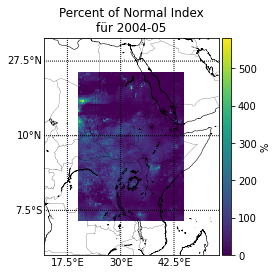

In [203]:
# temporäre Liste um geschachtelten percent_of_average_precip_stack in xarray zu überführen
temp_1d_list = []

for months in percent_of_average_precip_stack:
    for year in months:
        temp_1d_list.append(year)
        print(year)

# Verbinden entlang der Zeitachse
PNI_1d_stack = xr.concat(temp_1d_list, 'time' )

# Aus dem neuen xarray kann nun der ermittelte Minimalwert einfach abgefragt werden
global_minimum = PNI_1d_stack.sel(time= ( PNI_1d_stack.time == minimum_candidate.time ) )

plot_aoi(global_minimum[0], "Percent of Normal Index\nfür", "%") # idx 0 entspricht dem ersten (und einzigem) Zeitpunkt des xarrays

(array([[137.,  79.,  30., ...,   0.,   0.,   0.],
        [140.,  76.,  34., ...,   0.,   0.,   0.],
        [141.,  69.,  40., ...,   0.,   0.,   0.],
        ...,
        [230.,  20.,   0., ...,   0.,   0.,   0.],
        [230.,  20.,   0., ...,   0.,   0.,   0.],
        [231.,  18.,   1., ...,   0.,   0.,   0.]]),
 array([  0.     ,  58.178  , 116.356  , 174.53401, 232.712  , 290.89   ,
        349.06802, 407.24603, 465.424  , 523.60205, 581.78   ],
       dtype=float32),
 <a list of 350 BarContainer objects>)

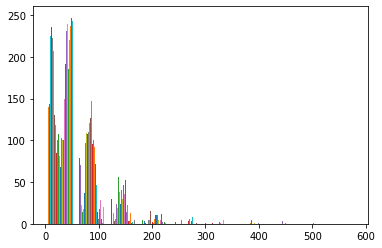

In [198]:
# Die Verteilung wird im Histogramm klarer
plt.hist( global_minimum[0] )

1772.781


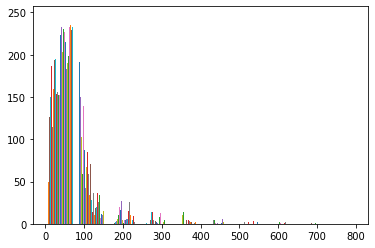

In [199]:
plt.hist(percent_of_average_precip_stack[0][14], range=(0, 800))
print(np.nanmax( percent_of_average_precip_stack[0][14] ))

In [200]:
plot_aoi(percent_of_average_precip_stack[0][14], "Percent of Normal Index\nfür", "%")

In [201]:
plt.hist(may_stack[0].values)

(array([[243.,   7.,   0., ...,   0.,   0.,   0.],
        [239.,  11.,   0., ...,   0.,   0.,   0.],
        [236.,  14.,   0., ...,   0.,   0.,   0.],
        ...,
        [250.,   0.,   0., ...,   0.,   0.,   0.],
        [250.,   0.,   0., ...,   0.,   0.,   0.],
        [250.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0.     ,  92.43061, 184.86122, 277.29184, 369.72244, 462.15305,
        554.5837 , 647.0143 , 739.4449 , 831.8755 , 924.3061 ],
       dtype=float32),
 <a list of 350 BarContainer objects>)